In [137]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

# Getting Data From Alpha Vantage
- In this implementation, we used Google and IBM data's from Alpha Vantage

In [138]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'C:\Users\PC\Desktop\api_key.txt')
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('IBM', '2020-01-01')
ibm

,open,high,low,close,adj close,volume
2020-01-02,135.00,135.92,134.770,135.42,125.596899,3148461.0
2020-01-03,133.57,134.86,133.560,134.34,124.595240,2373470.0
2020-01-06,133.42,134.24,133.200,134.10,124.372649,2421128.0
2020-01-07,133.69,134.96,133.400,134.19,124.456120,3267592.0
2020-01-08,134.51,135.86,133.920,135.31,125.494878,4345952.0
...,...,...,...,...,...,...
2021-07-02,146.91,146.95,139.460,140.02,140.020000,16828161.0
2021-07-06,139.99,140.42,137.100,138.78,138.780000,8093747.0
2021-07-07,138.76,140.33,138.760,139.82,139.820000,4059667.0
2021-07-08,137.78,141.31,137.660,140.74,140.740000,5487425.0


# RSI Implementation:

In [139]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
ibm

,open,high,low,close,adj close,volume,rsi_14
2020-01-08,134.51,135.86,133.920,135.31,125.494878,4345952.0,52.899154
2020-01-09,135.74,136.79,135.310,136.74,126.821148,3730549.0,71.911250
2020-01-10,137.00,137.87,136.310,136.69,126.774775,3255398.0,70.834622
2020-01-13,135.48,136.64,135.070,136.60,126.691304,3162843.0,68.836846
2020-01-14,136.28,137.14,135.550,135.82,125.967883,3680958.0,54.492657
...,...,...,...,...,...,...,...
2021-07-02,146.91,146.95,139.460,140.02,140.020000,16828161.0,36.450521
2021-07-06,139.99,140.42,137.100,138.78,138.780000,8093747.0,34.363205
2021-07-07,138.76,140.33,138.760,139.82,139.820000,4059667.0,37.591156
2021-07-08,137.78,141.31,137.660,140.74,140.740000,5487425.0,40.384214


# Plotting IBM Prices and RSI

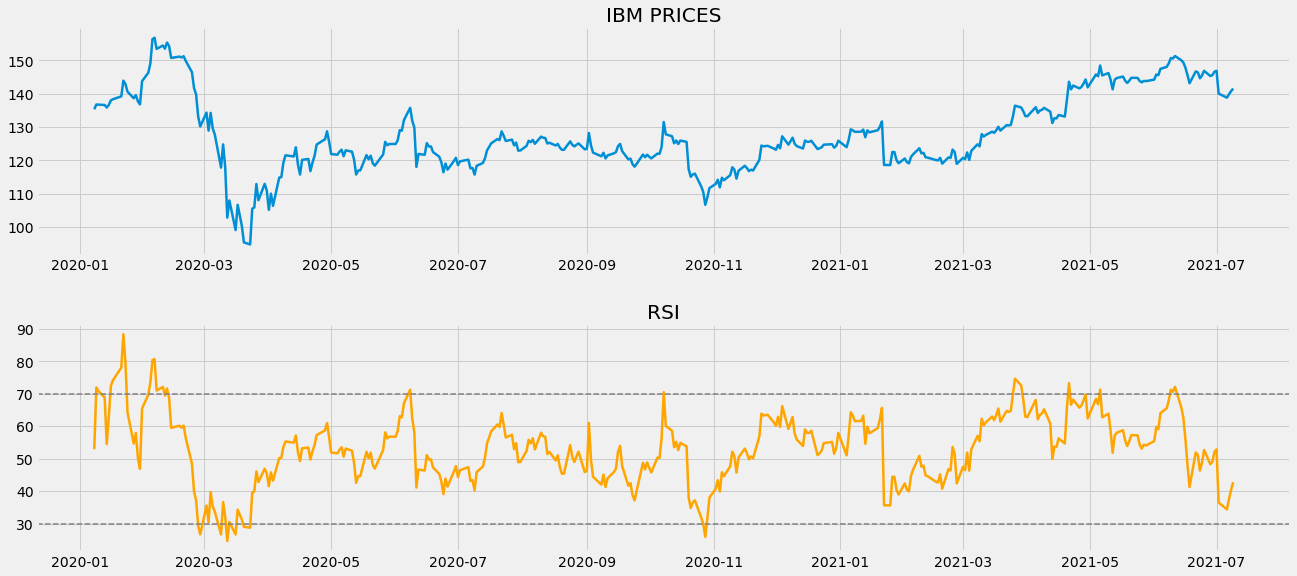

In [140]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('IBM PRICES')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('RSI')
plt.show()

# RSI Stimulants Implementation

In [141]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

# Plotting Trade Stimulants

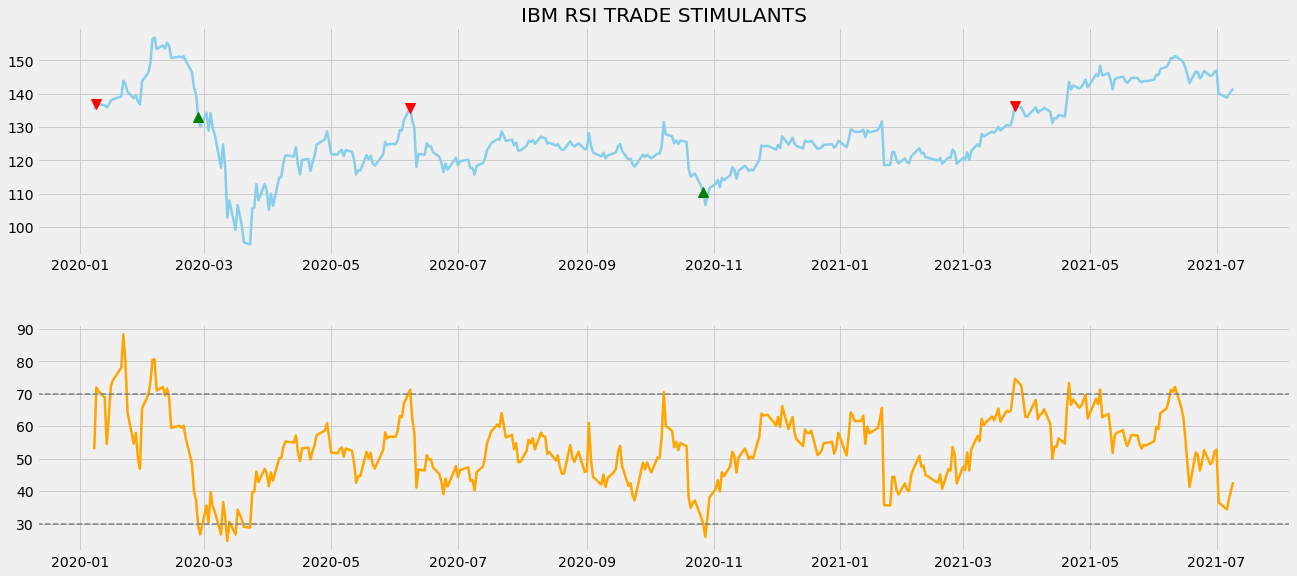

In [142]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('IBM RSI TRADE STIMULANTS')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

MACD Implementation:
=============================


In [143]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'C:\Users\PC\Desktop\api_key.txt')  #We get our api key from signing in alpha vantage
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('GOOGL', '2020-01-01')
googl

,open,high,low,close,adj close,volume
2020-01-02,1348.41,1368.68,1346.4900,1368.68,1368.68,1364265.0
2020-01-03,1348.00,1373.75,1347.3200,1361.52,1361.52,1170629.0
2020-01-06,1351.63,1398.32,1351.0000,1397.81,1397.81,2339343.0
2020-01-07,1400.46,1403.50,1391.5600,1395.11,1395.11,1726456.0
2020-01-08,1394.82,1411.85,1392.6300,1405.04,1405.04,1766274.0
...,...,...,...,...,...,...
2021-07-02,2463.00,2508.08,2461.1900,2505.15,2505.15,1300109.0
2021-07-06,2512.97,2528.56,2491.6501,2523.80,2523.80,1320179.0
2021-07-07,2543.24,2545.68,2523.0600,2529.48,2529.48,1202951.0
2021-07-08,2480.52,2511.91,2480.4400,2500.88,2500.88,1189467.0


In [144]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

,macd,signal,hist
2021-07-02,30.873673,31.021654,-0.147981
2021-07-06,34.611830,31.739689,2.872141
2021-07-07,37.599254,32.911602,4.687652
2021-07-08,37.229866,33.775255,3.454611
2021-07-09,37.273224,34.474848,2.798375


# Plotting MACD

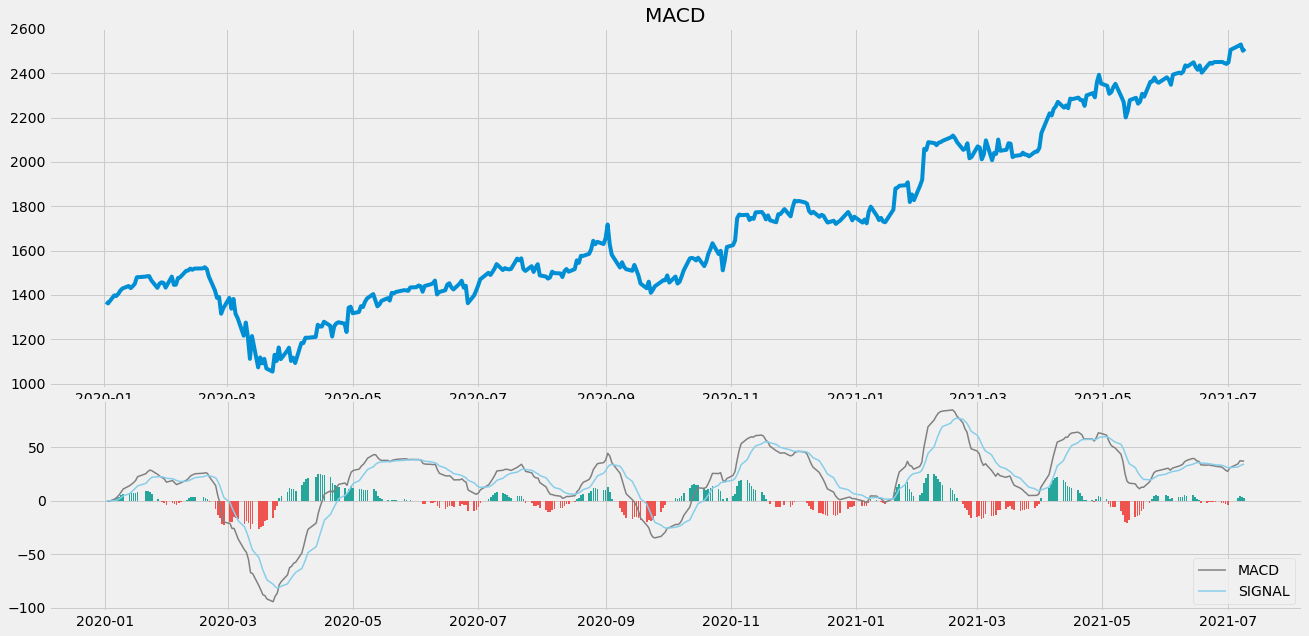

In [145]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)
    
    ax1.set_title('MACD')
    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

# MACD Stimulants Implementation

In [146]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

# Plotting Trade Stimulants

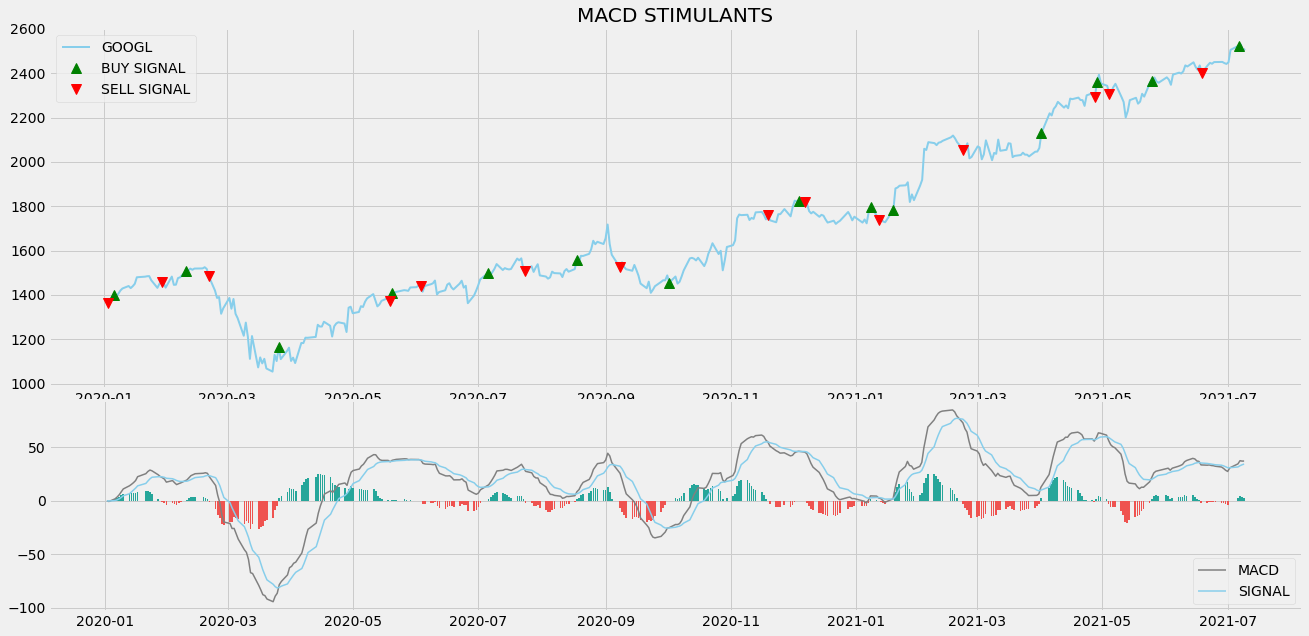

In [147]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('MACD STIMULANTS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()